# Усиление сигнала и игнорирование шума: введение в регуляризацию и группировку

#### Трехслойная сеть для классификации набора данных MNIST

In [1]:
import sys, numpy as np
from keras.datasets import mnist

# разделяем датасет на тренировочный и тестовый
(x_train, y_train), (x_test, y_test) = mnist.load_data()


images, labels = (x_train[0:1000].reshape(1000, 28*28)/255, y_train[0:1000])
one_hot_labels = np.zeros((len(labels), 10)) # create matrix fill with zeros, size is len(labels) and 10

for i, l in enumerate(labels):
    one_hot_labels[i][l] = 1
labels = one_hot_labels

test_images = x_test.reshape(len(x_test),28*28) / 255
test_labels = np.zeros((len(y_test),10))

for i,l in enumerate(y_test):
    test_labels[i][l] = 1

np.random.seed(1) # генерировать числа от 0 до 1

relu = lambda x:(x>=0) * x
relu2deriv = lambda x: x>=0

alpha, iterations, hidden_size, pixels_per_image, num_labels = (0.005, 350, 40, 784, 10)

# weights matrix
weights_0_1 = 0.2 * np.random.random((pixels_per_image, hidden_size)) - 0.1 # shape is (784, 40)
weights_1_2 = 0.2 * np.random.random((hidden_size, num_labels)) - 0.1 # shape is (40, 10)

for j in range(iterations):
    error, correct_cnt = (0.0, 0)
    
    for i in range(len(images)):
        layer_0 = images[i:i+1] # входной слой
        layer_1 = relu(np.dot(layer_0, weights_0_1)) 
        layer_2 = np.dot(layer_1, weights_1_2)
        error += np.sum((labels[i:i+1]-layer_2) ** 2) # compute error
        correct_cnt += int(np.argmax(layer_2) == np.argmax(labels[i:i+1])) # count how many correct answers we have
        
        layer_2_delta = labels[i:i+1] - layer_2
        layer_1_delta = layer_2_delta.dot(weights_1_2.T) * relu2deriv(layer_1)
        # change weight
        # formula is weight = alpha * input * weight_Delta
        weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)
        weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)
    sys.stdout.write("\r"+ " I:"+str(j)+ " Error:" + str(error/float(len(images)))[0:5] +" Correct:" + str(correct_cnt/float(len(images))))

 I:349 Error:0.108 Correct:1.099

# Проверяем нейросеть

In [4]:
if(j%10==0 or j == iterations - 1):
    
    error, correct_cnt = (0.0, 0)
    
    for i in range(len(test_images)):
        
        layer_0 = test_images[i:i+1]
        layer_1 = relu(np.dot(layer_0, weights_0_1))
        layer_2 = np.dot(layer_1, weights_1_2)
        
        error += np.sum((test_labels[i:i+1] - layer_2[i:i+1]) ** 2)
        correct_cnt += int(np.argmax(layer_2) == np.argmax(test_labels[i:i+1]))
        
    sys.stdout.write(" Test-Err:" + str(error/float(len(test_images)))[0:5] +\
                     " Test-Acc:" + str(correct_cnt/float(len(test_images))) + "\n")
        

 Test-Err:8.607 Test-Acc:0.7073


# Теперь добавим в сеть "прореживание". То есть в процессе обучения будем отключать случаные узлы сети

# В следущем фрагменте кода я использую пандас и матплотлиб для визуализации результатов сети

In [16]:
import sys, numpy as np
from keras.datasets import mnist
import pandas as pd
import matplotlib.pyplot as plt

dfTrain = pd.DataFrame(columns = ['Iteration','Error', 'Correct',])
dfTest = pd.DataFrame(columns = ['Test-Err','Test-Acc'])

# разделяем датасет на тренировочный и тестовый
(x_train, y_train), (x_test, y_test) = mnist.load_data()


images, labels = (x_train[0:1000].reshape(1000, 28*28)/255, y_train[0:1000])
one_hot_labels = np.zeros((len(labels), 10)) # create matrix fill with zeros, size is len(labels) and 10

for i, l in enumerate(labels):
    one_hot_labels[i][l] = 1
labels = one_hot_labels

test_images = x_test.reshape(len(x_test),28*28) / 255
test_labels = np.zeros((len(y_test),10))

for i,l in enumerate(y_test):
    test_labels[i][l] = 1

np.random.seed(1) # генерировать числа от 0 до 1

relu = lambda x:(x>=0) * x
relu2deriv = lambda x: x>=0

alpha, iterations, hidden_size, pixels_per_image, num_labels = (0.005, 350, 40, 784, 10)

# weights matrix
weights_0_1 = 0.2 * np.random.random((pixels_per_image, hidden_size)) - 0.1 # shape is (784, 40)
weights_1_2 = 0.2 * np.random.random((hidden_size, num_labels)) - 0.1 # shape is (40, 10)

for j in range(iterations):
    error, correct_cnt = (0.0, 0)
    
    for i in range(len(images)):
        layer_0 = images[i:i+1] # входной слой
        
        dropout_mask = np.random.randint(2,size=layer_1.shape) # создаем матрицу из 0 и 1 случайным образом, в последущем будем умножать их на 1 слой для отключения нейронов

        
        layer_1 = relu(np.dot(layer_0, weights_0_1)) 
        layer_1 *= dropout_mask * 2 # отключаем нейроны, умножая первый слой на бинарную матрицу, также умножаем на 2 потому что отключили половину нейронов

        layer_2 = np.dot(layer_1, weights_1_2)
        error += np.sum((labels[i:i+1]-layer_2) ** 2) # compute error
        correct_cnt += int(np.argmax(layer_2) == np.argmax(labels[i:i+1])) # count how many correct answers we have
        
        layer_2_delta = labels[i:i+1] - layer_2
        layer_1_delta = layer_2_delta.dot(weights_1_2.T) * relu2deriv(layer_1)
        layer_1_delta *= dropout_mask # отключаем нейроны
        # change weight
        # formula is weight = alpha * input * weight_Delta
        weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)
        weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)
    # append results to dataframe
    dfTrain = dfTrain.append({'Iteration':j,
                              'Error':error/float(len(images)),
                              'Correct':correct_cnt/float(len(images))},
                            ignore_index = True)
    sys.stdout.write("\r"+ " I:"+str(j)+ " Error:" + str(error/float(len(images)))[0:5] +" Correct:" + str(correct_cnt/float(len(images))))
    
if(j%10==0 or j == iterations - 1):
    
    error, correct_cnt = (0.0, 0)
    
    for i in range(len(test_images)):
        
        layer_0 = test_images[i:i+1]
        layer_1 = relu(np.dot(layer_0, weights_0_1))
        layer_2 = np.dot(layer_1, weights_1_2)
        
        error += np.sum((test_labels[i:i+1] - layer_2[i:i+1]) ** 2)
        correct_cnt += int(np.argmax(layer_2) == np.argmax(test_labels[i:i+1]))
    # append results to dataframe
        dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
                                'Test-Acc':correct_cnt/float(len(test_images))},
                              ignore_index = True)
    sys.stdout.write(" Test-Err:" + str(error/float(len(test_images)))[0:5] +
                     " Test-Acc:" + str(correct_cnt/float(len(test_images))) + "\n")
        

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:2 Error:0.669 Correct:0.559

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:5 Error:0.607 Correct:0.612

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:7 Error:0.582 Correct:0.625

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:9 Error:0.566 Correct:0.64

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:11 Error:0.569 Correct:0.638

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:13 Error:0.556 Correct:0.654

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:15 Error:0.544 Correct:0.673

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:16 Error:0.535 Correct:0.683

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:20 Error:0.530 Correct:0.681

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:22 Error:0.520 Correct:0.685

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:25 Error:0.513 Correct:0.698

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:26 Error:0.527 Correct:0.686

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:28 Error:0.500 Correct:0.713

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:31 Error:0.508 Correct:0.727

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:34 Error:0.480 Correct:0.716

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:37 Error:0.479 Correct:0.73

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:39 Error:0.483 Correct:0.733

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:41 Error:0.471 Correct:0.743

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:44 Error:0.475 Correct:0.727

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:47 Error:0.472 Correct:0.738

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:49 Error:0.448 Correct:0.766

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:51 Error:0.460 Correct:0.743

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:53 Error:0.472 Correct:0.739

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:55 Error:0.466 Correct:0.748

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:57 Error:0.462 Correct:0.729

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:61 Error:0.454 Correct:0.749

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:63 Error:0.448 Correct:0.756

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:65 Error:0.447 Correct:0.763

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:68 Error:0.465 Correct:0.751

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:71 Error:0.456 Correct:0.746

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:73 Error:0.445 Correct:0.774

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:75 Error:0.467 Correct:0.746

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:78 Error:0.447 Correct:0.777

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:81 Error:0.465 Correct:0.741

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:84 Error:0.457 Correct:0.771

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:86 Error:0.471 Correct:0.739

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:89 Error:0.459 Correct:0.762

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:92 Error:0.449 Correct:0.781

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:94 Error:0.439 Correct:0.769

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:96 Error:0.461 Correct:0.748

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:98 Error:0.445 Correct:0.799

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:101 Error:0.458 Correct:0.769

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:104 Error:0.449 Correct:0.773

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:106 Error:0.460 Correct:0.768

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:108 Error:0.458 Correct:0.758

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:110 Error:0.439 Correct:0.778

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:113 Error:0.448 Correct:0.776

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:114 Error:0.456 Correct:0.782

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:116 Error:0.445 Correct:0.78

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:118 Error:0.465 Correct:0.747

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:120 Error:0.451 Correct:0.778

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:122 Error:0.442 Correct:0.78

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:124 Error:0.427 Correct:0.786

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:126 Error:0.451 Correct:0.773

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:128 Error:0.453 Correct:0.761

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:130 Error:0.452 Correct:0.783

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:132 Error:0.464 Correct:0.758

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:134 Error:0.450 Correct:0.777

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:137 Error:0.449 Correct:0.789

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:140 Error:0.445 Correct:0.779

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:143 Error:0.446 Correct:0.778

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:145 Error:0.449 Correct:0.784

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:147 Error:0.463 Correct:0.767

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:150 Error:0.457 Correct:0.783

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:153 Error:0.443 Correct:0.782

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:155 Error:0.453 Correct:0.761

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:158 Error:0.446 Correct:0.776

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:160 Error:0.456 Correct:0.774

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:163 Error:0.447 Correct:0.772

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:166 Error:0.455 Correct:0.787

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:169 Error:0.438 Correct:0.782

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:171 Error:0.455 Correct:0.769

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:174 Error:0.434 Correct:0.784

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:176 Error:0.457 Correct:0.78

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:178 Error:0.450 Correct:0.775

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:181 Error:0.434 Correct:0.787

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:183 Error:0.440 Correct:0.776

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:185 Error:0.452 Correct:0.776

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:187 Error:0.437 Correct:0.783

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:190 Error:0.433 Correct:0.784

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:193 Error:0.457 Correct:0.77

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:198 Error:0.432 Correct:0.774

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local

 I:201 Error:0.438 Correct:0.784

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:204 Error:0.430 Correct:0.788

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:207 Error:0.456 Correct:0.771

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:210 Error:0.441 Correct:0.79

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:213 Error:0.443 Correct:0.78

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:215 Error:0.424 Correct:0.799

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:217 Error:0.431 Correct:0.787

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:220 Error:0.434 Correct:0.777

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:222 Error:0.433 Correct:0.795

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:224 Error:0.454 Correct:0.788

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:226 Error:0.428 Correct:0.784

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:228 Error:0.428 Correct:0.815

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:231 Error:0.436 Correct:0.773

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:234 Error:0.426 Correct:0.782

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:238 Error:0.410 Correct:0.796

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:240 Error:0.430 Correct:0.788

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:242 Error:0.436 Correct:0.784

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:244 Error:0.443 Correct:0.782

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:246 Error:0.422 Correct:0.796

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:248 Error:0.431 Correct:0.802

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:250 Error:0.433 Correct:0.789

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:252 Error:0.409 Correct:0.808

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:254 Error:0.406 Correct:0.813

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:256 Error:0.426 Correct:0.787

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:258 Error:0.408 Correct:0.808

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:260 Error:0.422 Correct:0.79

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:262 Error:0.437 Correct:0.79

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:264 Error:0.424 Correct:0.797

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:266 Error:0.419 Correct:0.794

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:268 Error:0.407 Correct:0.8

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:270 Error:0.430 Correct:0.803

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:272 Error:0.432 Correct:0.796

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:274 Error:0.405 Correct:0.818

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:276 Error:0.423 Correct:0.796

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:279 Error:0.415 Correct:0.817

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:281 Error:0.430 Correct:0.796

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:283 Error:0.411 Correct:0.815

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:285 Error:0.421 Correct:0.792

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:286 Error:0.419 Correct:0.81

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:288 Error:0.419 Correct:0.803

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:290 Error:0.428 Correct:0.792

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:294 Error:0.425 Correct:0.789

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:296 Error:0.428 Correct:0.788

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:298 Error:0.410 Correct:0.811

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:300 Error:0.407 Correct:0.804

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:302 Error:0.402 Correct:0.828

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:305 Error:0.417 Correct:0.804

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:307 Error:0.405 Correct:0.816

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:310 Error:0.415 Correct:0.793

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:312 Error:0.413 Correct:0.806

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:315 Error:0.410 Correct:0.812

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:317 Error:0.410 Correct:0.806

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:319 Error:0.432 Correct:0.784

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:321 Error:0.408 Correct:0.809

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:323 Error:0.407 Correct:0.815

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:325 Error:0.404 Correct:0.819

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:327 Error:0.386 Correct:0.832

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:329 Error:0.404 Correct:0.829

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:331 Error:0.416 Correct:0.803

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:334 Error:0.415 Correct:0.811

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:335 Error:0.378 Correct:0.826

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:337 Error:0.395 Correct:0.822

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:340 Error:0.408 Correct:0.814

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:342 Error:0.397 Correct:0.832

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:345 Error:0.408 Correct:0.806

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,


 I:347 Error:0.422 Correct:0.795

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTrain = dfTrain.append({'Iteration':j,
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/flo

 I:349 Error:0.418 Correct:0.802

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

 Test-Err:3.776 Test-Acc:0.8078


C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTest = dfTest.append({'Test-Err':error/float(len(test_images)),
C:\Users\aliha\AppData\Local\Temp\ipykernel_8196\2895730614.py:80: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

In [17]:
dfTrain

,Iteration,Error,Correct
0,0.0,0.885415,0.289
1,1.0,0.716466,0.5
2,2.0,0.669194,0.559
3,3.0,0.628167,0.589
4,4.0,0.621648,0.588
...,...,...,...
345,345.0,0.408302,0.806
346,346.0,0.389441,0.826
347,347.0,0.422398,0.795
348,348.0,0.408873,0.814


In [18]:
dfTest

,Test-Err,Test-Acc
0,0.000004,0.0001
1,0.000004,0.0001
2,0.000004,0.0002
3,0.000004,0.0003
4,0.000004,0.0004
...,...,...
9995,0.000004,0.8075
9996,0.000004,0.8076
9997,0.000004,0.8077
9998,0.000004,0.8077


## In plot below, visualisation of train data

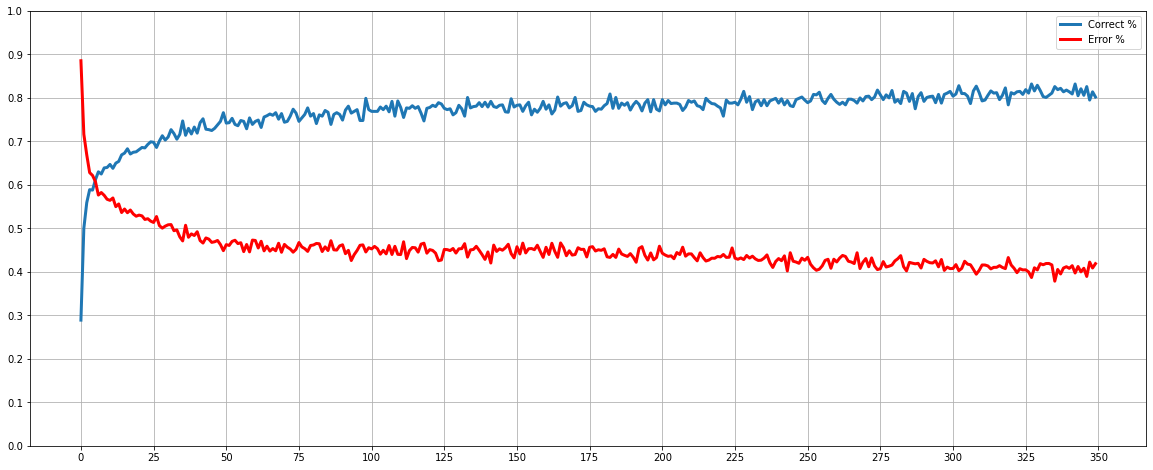

In [35]:
plt.figure(figsize=(20,8))
plt.plot(dfTrain['Iteration'],dfTrain['Correct'], label = 'Correct %', linewidth=3)
plt.plot(dfTrain['Iteration'],dfTrain['Error'], label = 'Error %', linewidth=3, color = 'red')
plt.xticks(np.arange(0, 351, 25))
plt.yticks(np.arange(0,1.01,0.1))
plt.legend()
plt.grid()

# Visualisation of test data

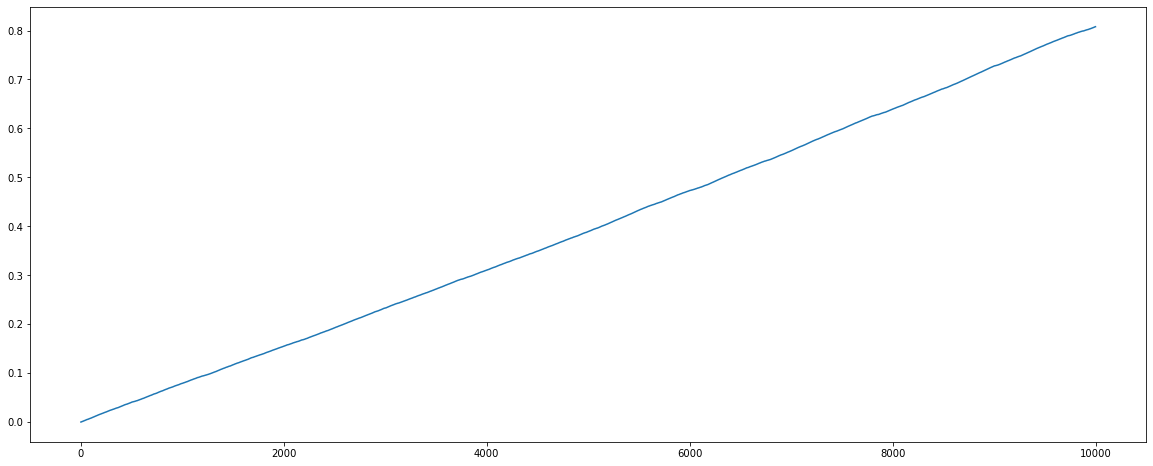

In [37]:
plt.figure(figsize=(20,8))
xAxis = np.arange(0,1000, 100)

plt.plot(dfTest['Test-Acc'])

In [8]:
len(weights_0_1[0])


40

In [7]:
len(weights_1_2[0])

10